# King County Real Estate
## Designing Data-Driven Price Model

###### <font color='gray'>By: Jeonwook Kang, Daniel Burdeno, Roger Pineda</font>

# Overview
**This project analyzes King County housing sales data to create both predictive and inferential price model**

The project highlights four key features that most strongly impacts our housing price:
- Square feet
- Zip code
- Water Front 
- View

# Business Problem
As a real estate agency firm, their primary role is to connect potential buyers and sellers of real estate properties. It is therefore imperative that they provide an accurate information and services to their clients and ensure both parties consent on a fair property price. Every Door Real Estate Company needs a model that provides statistically significant information on features that impact housing value and predicts a fair price based on those features and will make ssure the client is content on their decision of choosing Every Door Real Estate Company.

Key questions:
- Which specific features significantly influence the overall value of the house?
- How significant are the locations of the house within King County?
- Is it possible to predict the housing price based on its features?
- How can Every Door Real Estate Company utilize this model to increase their profit?

----

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
# Loading in the given data set into variable housing_df to check the data type for each column
housing_df = pd.read_csv('data/kc_house_data.csv')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
# Checking to see if any columns in the dataframe have any NaN values
housing_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Observations**
<ul>
<li> We see waterfront, view and yr_renocated columns are the only columns with NaN values.
<li> We will be using sklearn Simple Imputer to later fill in the missing values in our desired columns.
<li> Also there are many columns with non-numerical values, so we will convert those values into integers using an appropriate sklearn tools. 

In [4]:
# Grabbing the age of the home
housing_df['datetime'] = pd.to_datetime(housing_df['date'])
housing_df['soldyear'] = housing_df['datetime'].dt.year
housing_df['age_when_sold'] = housing_df['soldyear'] - housing_df['yr_built']

In [5]:
# Just getting the numeric values of Graade
housing_df['grade_num'] = housing_df['grade'].str.split()
housing_df['grade_num'] = housing_df['grade_num'].str[0]
housing_df['grade_num'] = housing_df['grade_num'].astype(int)

In [6]:
# Creating a new column 'Basement' that will have a value of 1 or 0 in reference to whther a house has a basement or not.
housing_df['sqft_basement'] = housing_df['sqft_living'] - housing_df['sqft_above']
housing_df['Basement'] = None
housing_df['Basement'] = housing_df['sqft_basement'].map(lambda x: False if x == 0 else True)
housing_df['Basement'] = housing_df['Basement'].astype(int)

In [7]:
housing_df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [8]:
# Changing all the values in the 'condition' column to integers.
replace_dict2 = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
housing_df['condition'] = housing_df['condition'].replace(replace_dict2)

In [9]:
wtr_col = housing_df[['waterfront']]
imputer = SimpleImputer(strategy='constant', fill_value = 'NO')
imputer.fit(wtr_col)
waterfront_imputed = imputer.transform(wtr_col)
housing_df.waterfront = waterfront_imputed

In [10]:
wtr_col = housing_df[['waterfront']]
encoder_wtr = OrdinalEncoder()
encoder_wtr.fit(wtr_col)
encoded_wtr = encoder_wtr.transform(wtr_col)
encoded_wtr = encoded_wtr.flatten()
housing_df.waterfront = encoded_wtr

In [11]:
view_col = housing_df[['view']]
imputer = SimpleImputer(strategy='constant', fill_value = 'NONE')
imputer.fit(view_col)
view_imputed = imputer.transform(view_col)
housing_df.view = view_imputed

In [12]:
housing_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
datetime            0
soldyear            0
age_when_sold       0
grade_num           0
Basement            0
dtype: int64

We don't see much usage in certain columns or we have already used the column information to its max and will no longer be needing them.

In [13]:
housing_ols = housing_df.drop(['datetime', 'date', 'soldyear', 'yr_built', 'lat', 'long',
 'sqft_above', 'sqft_lot15', 'sqft_living15', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated'], axis = 1)

In [14]:
housing_ols

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,zipcode,age_when_sold,grade_num,Basement
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,NONE,3,98178,59,7,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,NONE,3,98125,63,7,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,NONE,3,98028,82,6,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,NONE,5,98136,49,7,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,NONE,3,98074,28,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,NONE,3,98103,5,8,0
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,NONE,3,98146,1,8,0
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,NONE,3,98144,5,7,0
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0.0,NONE,3,98027,11,8,0


In [15]:
housing_ols['bathrooms'] = housing_ols['bathrooms'][housing_ols['bathrooms'].between(housing_ols['bathrooms'].quantile(.025), housing_ols['bathrooms'].quantile(.975), inclusive=True)]
housing_ols['floors'] = housing_ols['floors'][housing_ols['floors'].between(housing_ols['floors'].quantile(.025), housing_ols['floors'].quantile(.975), inclusive=True)]
housing_ols['condition'] = housing_ols['condition'][housing_ols['condition'].between(housing_ols['condition'].quantile(.025), housing_ols['condition'].quantile(.975), inclusive=True)]
housing_ols['age_when_sold'] = housing_ols['age_when_sold'][housing_ols['age_when_sold'].between(housing_ols['age_when_sold'].quantile(.025), housing_ols['age_when_sold'].quantile(.975), inclusive=True)]
housing_ols['grade_num'] = housing_ols['grade_num'][housing_ols['grade_num'].between(housing_ols['grade_num'].quantile(.025), housing_ols['grade_num'].quantile(.975), inclusive=True)]
housing_ols['sqft_living'] = housing_ols['sqft_living'][housing_ols['sqft_living'].between(housing_ols['sqft_living'].quantile(.025), housing_ols['sqft_living'].quantile(.975), inclusive=True)]

In [16]:
housing_ols.dropna(inplace=True)

In [17]:
housing_ols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18982 entries, 0 to 21595
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18982 non-null  int64  
 1   price          18982 non-null  float64
 2   bedrooms       18982 non-null  int64  
 3   bathrooms      18982 non-null  float64
 4   sqft_living    18982 non-null  float64
 5   sqft_lot       18982 non-null  int64  
 6   floors         18982 non-null  float64
 7   waterfront     18982 non-null  float64
 8   view           18982 non-null  object 
 9   condition      18982 non-null  float64
 10  zipcode        18982 non-null  int64  
 11  age_when_sold  18982 non-null  float64
 12  grade_num      18982 non-null  float64
 13  Basement       18982 non-null  int32  
dtypes: float64(8), int32(1), int64(4), object(1)
memory usage: 2.1+ MB


With new working dataframe we want to see how the remaining columns correlates to our target,price, as well as to other columns to check for collinearity

In [18]:
housing_ols.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,zipcode,age_when_sold,grade_num,Basement
id,1.000000,-0.000928,0.008006,0.023486,0.007682,-0.133692,0.028339,-0.001261,-0.027560,-0.010194,-0.028447,0.023935,-0.002596
price,-0.000928,1.000000,0.240653,0.410585,0.602894,0.069183,0.206349,0.199812,0.063917,-0.013711,0.025395,0.606747,0.167110
bedrooms,0.008006,0.240653,1.000000,0.428823,0.538763,0.019597,0.106570,-0.018726,0.039335,-0.128411,-0.091938,0.254965,0.128265
bathrooms,0.023486,0.410585,0.428823,1.000000,0.681695,0.057580,0.489728,0.026091,-0.144666,-0.189508,-0.515920,0.586130,0.114819
sqft_living,0.007682,0.602894,0.538763,0.681695,1.000000,0.149898,0.303125,0.052234,-0.057134,-0.178894,-0.279177,0.685861,0.171674
sqft_lot,-0.133692,0.069183,0.019597,0.057580,0.149898,1.000000,-0.019939,0.024670,0.002893,-0.121881,-0.041776,0.092503,-0.045031
floors,0.028339,0.206349,0.106570,0.489728,0.303125,-0.019939,1.000000,0.009563,-0.291515,-0.050391,-0.506532,0.427576,-0.308340
waterfront,-0.001261,0.199812,-0.018726,0.026091,0.052234,0.024670,0.009563,1.000000,0.020148,0.037290,0.041026,0.047250,0.032024
condition,-0.027560,0.063917,0.039335,-0.144666,-0.057134,0.002893,-0.291515,0.020148,1.000000,0.002346,0.397815,-0.170227,0.144455
zipcode,-0.010194,-0.013711,-0.128411,-0.189508,-0.178894,-0.121881,-0.050391,0.037290,0.002346,1.000000,0.340941,-0.166271,0.193399


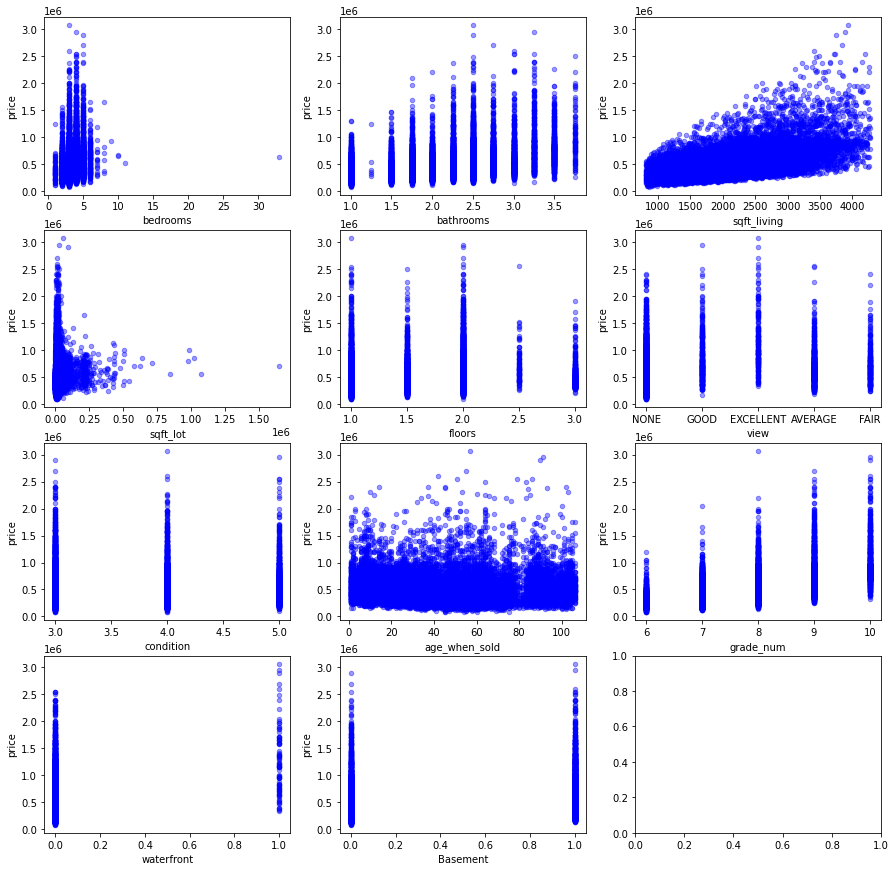

In [19]:
# Visually inspecting all columns association with price
fig, (axes1, axes2, axes3, axes4) = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
for xcol, ax in zip(['bedrooms', 'bathrooms', 'sqft_living'], axes1):
    housing_ols.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')
for xcols, axs in zip(['sqft_lot', 'floors', 'view'], axes2):
    housing_ols.plot(kind='scatter', x=xcols, y='price', ax=axs, alpha=0.4, color='b')
for xcolss, axss in zip(['condition', 'age_when_sold', 'grade_num'], axes3):
    housing_ols.plot(kind='scatter', x=xcolss, y='price', ax=axss, alpha=0.4, color='b')
for xcolss, axss in zip(['waterfront', 'Basement'], axes4):
    housing_ols.plot(kind='scatter', x=xcolss, y='price', ax=axss, alpha=0.4, color='b')

In [20]:
housing_pred = housing_ols.copy()

In [21]:
# All of these columns are categorical values so we will we will create separate columns with OneHotEncoder. 
# Using the new columns found within each categories, we will concat them all into one dataframe.
# Categorical columns include: 'bedrooms', 'grade_num', 'condition', 'bahrooms', 'view', 'floors', 'zipcode'

bedrooms_ohe = housing_pred[['bedrooms']]
ohe_bedrooms = OneHotEncoder(categories ='auto', sparse =False)
ohe_bedrooms.fit(bedrooms_ohe)
ohe_bedrooms_encoded = ohe_bedrooms.transform(bedrooms_ohe)
bedrooms_encoded_ohe = pd.DataFrame(ohe_bedrooms_encoded, columns = ohe_bedrooms.get_feature_names(['bedrooms']), index = housing_pred.index )
housing_pred1 = pd.concat([housing_pred, bedrooms_encoded_ohe ], axis =1)

In [22]:
grade_num_ohe = housing_pred[['grade_num']]
ohe_grade_num = OneHotEncoder(categories ='auto', sparse =False)
ohe_grade_num.fit(grade_num_ohe)
ohe_grade_num_encoded = ohe_grade_num.transform(grade_num_ohe)
grade_num_encoded_ohe = pd.DataFrame(ohe_grade_num_encoded, columns = ohe_grade_num.get_feature_names(['grade_num']), index = housing_pred.index )
housing_pred2 = pd.concat([housing_pred1, grade_num_encoded_ohe], axis =1)

In [23]:
condition_ohe = housing_pred[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False)
cond_encoded_ohe = pd.DataFrame (ohe.fit_transform(condition_ohe), index = housing_pred.index)
cond_encoded_ohe.columns = ohe.get_feature_names(['condition'])
housing_pred3 = pd.concat([housing_pred2, cond_encoded_ohe], axis = 1)

In [24]:
bathrooms_ohe = housing_pred[['bathrooms']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
bathrooms_transform = ohe.fit_transform(bathrooms_ohe)
bathrooms_encoded_ohe = pd.DataFrame(bathrooms_transform, columns=ohe.get_feature_names(['bathrooms']), index=housing_pred.index)
housing_pred4 = pd.concat([housing_pred3, bathrooms_encoded_ohe], axis = 1)

In [25]:
view_ohe = housing_pred[['view']]
ohe = OneHotEncoder(categories="auto", sparse=False)
ohe.fit(view_ohe)
view_encoded = ohe.transform(view_ohe)
view_encoded_ohe =pd.DataFrame(view_encoded, columns=ohe.get_feature_names(['view']), index=housing_pred.index)
housing_pred5 = pd.concat([housing_pred4, view_encoded_ohe], axis = 1)

In [26]:
floors_ohe = housing_pred[['floors']]
ohe_floors = OneHotEncoder(categories ='auto', sparse =False)
ohe_floors.fit(floors_ohe)
ohe_floors_encoded = ohe_floors.transform(floors_ohe)
floors_encoded_ohe = pd.DataFrame(ohe_floors_encoded, columns = ohe_floors.get_feature_names(['floors']), index = housing_pred.index )
housing_pred6 = pd.concat([housing_pred5, floors_encoded_ohe ], axis =1)

In [27]:
zipcode_ohe = housing_pred[['zipcode']]
ohe = OneHotEncoder(categories="auto", sparse=False)
ohe.fit(zipcode_ohe)
zipcode_encoded = ohe.transform(zipcode_ohe)
zipcode_encoded_ohe =pd.DataFrame(zipcode_encoded, columns=ohe.get_feature_names(['zipcode']), index=housing_pred.index)
housing_pred_final = pd.concat([housing_pred6, zipcode_encoded_ohe ], axis =1)

In [28]:
# Final dataframe after dealing with the catgoricals and dropping the original columns.
housing_pred_final.drop(['id', 'floors', 'bedrooms', 'bathrooms', 'view', 'condition', 'zipcode', 'grade_num'], axis = 1, inplace=True)

Finally we want to log transform our target variable, price, in order to account for heteroscesdsitdy in the data

In [29]:
# Creating a new column that takes the log of price
housing_pred_final['log_price'] = np.log(housing_pred_final['price'])

# Predictive Model Results

### Dummy Regressor (Baseline)

In [30]:
# Putting our target in the y_dummy variable and the rest of the dataframe without price in the X_dummy variable
X_dummy = housing_pred_final.drop('price', axis = 1)
y_dummy = housing_pred_final['log_price']

# Splitting up our dummy variables into two subsets: for training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=42)

# Setting up our dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
print(dummy_regr.score(X_train, y_train))
print(dummy_regr.score(X_test, y_test))

0.0
-1.7223170907021412e-05


### Simple Regression

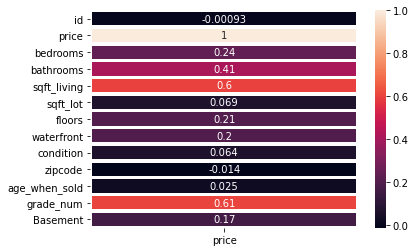

In [32]:
heat_map = housing_pred.corr()
heat_map_price = heat_map[['price']]
sns.heatmap(heat_map_price, annot=True, linewidths =2.5);

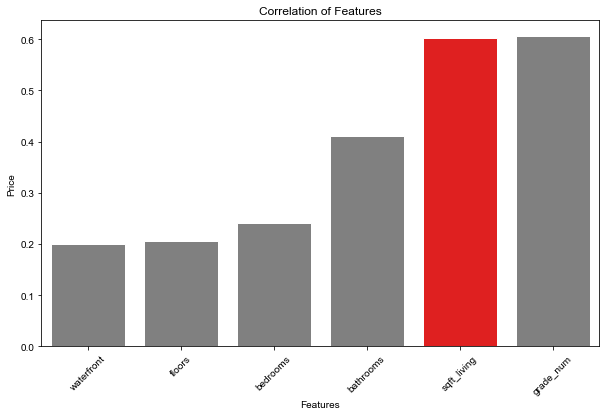

In [33]:
heat_map_price = heat_map_price.reset_index().sort_values(by='price', ascending=True)
heat_map_price = heat_map_price[(heat_map_price['index']=='sqft_living')|
                                (heat_map_price['index']=='grade_num')|
                                (heat_map_price['index']=='bathrooms')|
                                (heat_map_price['index']=='bedrooms')|
                                (heat_map_price['index']=='waterfront')|
                                (heat_map_price['index']=='floors')]

heat_fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("dark")
x_cor = heat_map_price['index']
y_cor = heat_map_price['price']
clrs=['grey' if (x != 'sqft_living') else 'red' for x in x_cor]

sns.barplot(x=x_cor, y=y_cor, palette=clrs, ax=ax)
ax.tick_params(axis='x', rotation=45)
plt.title('Correlation of Features')
plt.ylabel('Price')
plt.xlabel('Features')
plt.savefig('images/heat_fig.png', bbox_inches = 'tight');

**We see from above that sqft_living has the highest correlation from non-catergorical to price therefore it will be used as the feature in the simple model.**

In [34]:
# y variable will always be our target which is price and X variable will contain our housing features
# Here in our simple model, X is only sqft_living
simple_model_df = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living']], axis = 1)
X_simple = simple_model_df.drop('log_price', axis = 1)
y_simple = simple_model_df['log_price']

# Splitting up our dummy variables into two subsets: for training data and testing data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_s[cols_scale])
scaled_columns = scaled_fit.transform(X_train_s[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_s.index)
scaled_columns.columns = cols_scale
X_train_s['sqft_living'] = scaled_columns['sqft_living']

# Setting up simple linear regression
simple_reg = LinearRegression()
simple_reg.fit(X_train_s, y_train_s)
print(simple_reg.score(X_train_s, y_train_s))

# Scaling test set
scale_test = X_test_s[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_s.index)
scaled_columns_test.columns = cols_scale
X_test_s['sqft_living'] = scaled_columns_test['sqft_living']
print(simple_reg.score(X_test_s, y_test_s))

# Calculating predicted value of our model 
# determine the mean squared error for train and test data
y_hat_train_s = np.exp(simple_reg.predict(X_train_s))
y_hat_test_s = np.exp(simple_reg.predict(X_test_s))
train_mse_s = mean_squared_error(np.exp(y_train_s), y_hat_train_s)
test_mse_s = mean_squared_error(np.exp(y_test_s), y_hat_test_s)
test_rmse_s = np.sqrt(test_mse_s)
print('Train Mean Squarred Error:', train_mse_s)
print('Test Mean Squarred Error:', test_mse_s)
print('Test RMSE: ', test_rmse_s)

0.3814740612115821
0.37977233074408945
Train Mean Squarred Error: 45436829723.37744
Test Mean Squarred Error: 44990685853.56912
Test RMSE:  212110.0795661751


<ipython-input-34-e9403d6fd8c2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_s['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-34-e9403d6fd8c2>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_s['sqft_living'] = scaled_columns_test['sqft_living']


### Multiple Linear Regression

#### Model 1

In [35]:
# y variable will always be our target which is price and X variable will contain our housing features
# This is our first muliple linear regression model with just sqft_living and view
multi_model_1 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], view_encoded_ohe], axis = 1)
X_multi1 = multi_model_1.drop('log_price', axis = 1)
y_multi1 = multi_model_1['log_price']

# Splitting up our dummy variables into two subsets: for training data and testing data
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_multi1, y_multi1, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m1[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m1[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m1.index)
scaled_columns.columns = cols_scale
X_train_m1['sqft_living'] = scaled_columns['sqft_living']

# Setting up our first multiple linear regression
multi1_reg = LinearRegression()
multi1_reg.fit(X_train_m1, y_train_m1)
print(multi1_reg.score(X_train_m1, y_train_m1))

# Scaling test set
scale_test = X_test_m1[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m1.index)
scaled_columns_test.columns = cols_scale
X_test_m1['sqft_living'] = scaled_columns_test['sqft_living']
print(multi1_reg.score(X_test_m1, y_test_m1))

# Calculating predicted value of our model 
# determine the mean squared error for train and test data
y_hat_train_m1 = np.exp(multi1_reg.predict(X_train_m1))
y_hat_test_m1 = np.exp(multi1_reg.predict(X_test_m1))
train_mse_m1 = mean_squared_error(np.exp(y_train_m1), y_hat_train_m1)
test_mse_m1 = mean_squared_error(np.exp(y_test_m1), y_hat_test_m1)
test_rmse_m1 = np.sqrt(test_mse_m1)
print('Train Mean Squarred Error:', train_mse_m1)
print('Test Mean Squarred Error:', test_mse_m1)
print('Test RSME: ', test_rmse_m1)

0.41453618170362183
0.4142344036118253
Train Mean Squarred Error: 40957081705.36291
Test Mean Squarred Error: 40367024472.9461
Test RSME:  200915.4659874299


<ipython-input-35-0c364ecdab16>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m1['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-35-0c364ecdab16>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m1['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 2

In [36]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 2

multi_model_2 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], view_encoded_ohe, cond_encoded_ohe], axis = 1)
X_multi2 = multi_model_2.drop('log_price', axis = 1)
y_multi2 = multi_model_2['log_price']

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_multi2, y_multi2, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m2[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m2[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m2.index)
scaled_columns.columns = cols_scale
X_train_m2['sqft_living'] = scaled_columns['sqft_living']

multi2_reg = LinearRegression()
multi2_reg.fit(X_train_m2, y_train_m2)
print(multi2_reg.score(X_train_m2, y_train_m2))

# Scaling test set
scale_test = X_test_m2[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m2.index)
scaled_columns_test.columns = cols_scale
X_test_m2['sqft_living'] = scaled_columns_test['sqft_living']
print(multi2_reg.score(X_test_m2, y_test_m2))

y_hat_train_m2 = multi2_reg.predict(X_train_m2)
y_hat_test_m2 = multi2_reg.predict(X_test_m2)
train_mse_m2 = mean_squared_error(y_train_m2, y_hat_train_m2)
test_mse_m2 = mean_squared_error(y_test_m2, y_hat_test_m2)
print('Train Mean Squarred Error:', train_mse_m2)
print('Test Mean Squarred Error:', test_mse_m2)

0.4207979397125764
0.42064605615149897
Train Mean Squarred Error: 0.1266418740188215
Test Mean Squarred Error: 0.126588192904155


<ipython-input-36-aa8a41f7274c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m2['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-36-aa8a41f7274c>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m2['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 3

In [37]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 3

multi_model_3 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], zipcode_encoded_ohe], axis = 1)
X_multi3 = multi_model_3.drop('log_price', axis = 1)
y_multi3 = multi_model_3['log_price']

X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(X_multi3, y_multi3, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m3[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m3[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m3.index)
scaled_columns.columns = cols_scale
X_train_m3['sqft_living'] = scaled_columns['sqft_living']

multi3_reg = LinearRegression()
multi3_reg.fit(X_train_m3, y_train_m3)
print(multi3_reg.score(X_train_m3, y_train_m3))

# Scaling test set
scale_test = X_test_m3[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m3.index)
scaled_columns_test.columns = cols_scale
X_test_m3['sqft_living'] = scaled_columns_test['sqft_living']
print(multi3_reg.score(X_test_m3, y_test_m3))

y_hat_train_m3 = multi3_reg.predict(X_train_m3)
y_hat_test_m3 = multi3_reg.predict(X_test_m3)
train_mse_m3 = mean_squared_error(y_train_m3, y_hat_train_m3)
test_mse_m3 = mean_squared_error(y_test_m3, y_hat_test_m3)
print('Train Mean Squarred Error:', train_mse_m3)
print('Test Mean Squarred Error:', test_mse_m3)

0.8077780878874463
0.8023505472227561
Train Mean Squarred Error: 0.042029103220618466
Test Mean Squarred Error: 0.04318618578716206


<ipython-input-37-b54327c02ec4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m3['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-37-b54327c02ec4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m3['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 4

In [41]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 4

multi_model_4 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], zipcode_encoded_ohe, bathrooms_encoded_ohe], axis = 1)
X_multi4 = multi_model_4.drop('log_price', axis = 1)
y_multi4 = multi_model_4['log_price']

X_train_m4, X_test_m4, y_train_m4, y_test_m4 = train_test_split(X_multi4, y_multi4, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m4[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m4[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m4.index)
scaled_columns.columns = cols_scale
X_train_m4['sqft_living'] = scaled_columns['sqft_living']

multi4_reg = LinearRegression()
multi4_reg.fit(X_train_m4, y_train_m4)
print(multi4_reg.score(X_train_m4, y_train_m4))

# Scaling test set
scale_test = X_test_m4[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m4.index)
scaled_columns_test.columns = cols_scale
X_test_m4['sqft_living'] = scaled_columns_test['sqft_living']
print(multi4_reg.score(X_test_m4, y_test_m4))


0.8095778717064409
0.8033340420975328


<ipython-input-41-66268b2c37bf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m4['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-41-66268b2c37bf>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m4['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 5

In [39]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 5

multi_model_5 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], zipcode_encoded_ohe, bedrooms_encoded_ohe], axis = 1)
X_multi5 = multi_model_5.drop('log_price', axis = 1)
y_multi5 = multi_model_5['log_price']

X_train_m5, X_test_m5, y_train_m5, y_test_m5 = train_test_split(X_multi5, y_multi5, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m5[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m5[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m5.index)
scaled_columns.columns = cols_scale
X_train_m5['sqft_living'] = scaled_columns['sqft_living']

multi5_reg = LinearRegression()
multi5_reg.fit(X_train_m5, y_train_m5)
print(multi5_reg.score(X_train_m5, y_train_m5))

# Scaling test set
scale_test = X_test_m5[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m5.index)
scaled_columns_test.columns = cols_scale
X_test_m5['sqft_living'] = scaled_columns_test['sqft_living']
print(multi5_reg.score(X_test_m5, y_test_m5))

y_hat_train_m5 = multi5_reg.predict(X_train_m5)
y_hat_test_m5 = multi5_reg.predict(X_test_m5)
train_mse_m5 = mean_squared_error(y_train_m5, y_hat_train_m5)
test_mse_m5 = mean_squared_error(y_test_m5, y_hat_test_m5)
print('Train Mean Squarred Error:', train_mse_m5)
print('Test Mean Squarred Error:', test_mse_m5)

0.8106186460902515
0.8064459905448146
Train Mean Squarred Error: 0.041408018389041255
Test Mean Squarred Error: 0.042291335972492745


<ipython-input-39-870ca2e432c9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m5['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-39-870ca2e432c9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m5['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 6

In [40]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 6

multi_model_6 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], zipcode_encoded_ohe, view_encoded_ohe], axis = 1)
X_multi6 = multi_model_6.drop('log_price', axis = 1)
y_multi6 = multi_model_6['log_price']

X_train_m6, X_test_m6, y_train_m6, y_test_m6 = train_test_split(X_multi6, y_multi6, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m6[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m6[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m6.index)
scaled_columns.columns = cols_scale
X_train_m6['sqft_living'] = scaled_columns['sqft_living']

multi6_reg = LinearRegression()
multi6_reg.fit(X_train_m6, y_train_m6)
print(multi6_reg.score(X_train_m6, y_train_m6))

# Scaling test set
scale_test = X_test_m6[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m6.index)
scaled_columns_test.columns = cols_scale
X_test_m6['sqft_living'] = scaled_columns_test['sqft_living']
print(multi6_reg.score(X_test_m6, y_test_m6))

y_hat_train_m6 = multi6_reg.predict(X_train_m6)
y_hat_test_m6 = multi6_reg.predict(X_test_m6)
train_mse_m6 = mean_squared_error(y_train_m6, y_hat_train_m6)
test_mse_m6 = mean_squared_error(y_test_m6, y_hat_test_m6)
print('Train Mean Squarred Error:', train_mse_m6)
print('Test Mean Squarred Error:', test_mse_m6)

0.8308539953465607
0.8234092241304493
Train Mean Squarred Error: 0.036983582208733684
Test Mean Squarred Error: 0.03858488828500088


<ipython-input-40-3355172ce715>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m6['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-40-3355172ce715>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m6['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 7

In [42]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 7

multi_model_7 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], housing_pred_final['waterfront'], zipcode_encoded_ohe, view_encoded_ohe], axis = 1)
X_multi7 = multi_model_7.drop('log_price', axis = 1)
y_multi7 = multi_model_7['log_price']

X_train_m7, X_test_m7, y_train_m7, y_test_m7 = train_test_split(X_multi7, y_multi7, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m7[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m7[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m7.index)
scaled_columns.columns = cols_scale
X_train_m7['sqft_living'] = scaled_columns['sqft_living']

multi7_reg = LinearRegression()
multi7_reg.fit(X_train_m7, y_train_m7)
print(multi7_reg.score(X_train_m7, y_train_m7))

# Scaling test set
scale_test = X_test_m7[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m7.index)
scaled_columns_test.columns = cols_scale
X_test_m7['sqft_living'] = scaled_columns_test['sqft_living']
print(multi7_reg.score(X_test_m7, y_test_m7))

y_hat_train_m7 = multi7_reg.predict(X_train_m7)
y_hat_test_m7 = multi7_reg.predict(X_test_m7)
train_mse_m7 = mean_squared_error(y_train_m7, y_hat_train_m7)
test_mse_m7 = mean_squared_error(y_test_m7, y_hat_test_m7)
print('Train Mean Squarred Error:', train_mse_m7)
print('Test Mean Squarred Error:', test_mse_m7)

0.8335362938112512
0.826339376334434
Train Mean Squarred Error: 0.03639710068952492
Test Mean Squarred Error: 0.037944653284661366


<ipython-input-42-530bf82454e8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m7['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-42-530bf82454e8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m7['sqft_living'] = scaled_columns_test['sqft_living']


#### Model 8

In [43]:
# Above Steps repeated with different combinations of housing features to see if it improves our model
# Multiple Linear Regression Model number 8

multi_model_8 = pd.concat([housing_pred_final['log_price'], housing_pred_final['sqft_living'], housing_pred_final['waterfront'],
                           housing_pred_final['Basement'], zipcode_encoded_ohe, view_encoded_ohe, 
                           cond_encoded_ohe, floors_encoded_ohe, bathrooms_encoded_ohe, bedrooms_encoded_ohe, grade_num_encoded_ohe], axis = 1)
X_multi8 = multi_model_8.drop('log_price', axis = 1)
y_multi8 = multi_model_8['log_price']

X_train_m8, X_test_m8, y_train_m8, y_test_m8 = train_test_split(X_multi8, y_multi8, test_size=0.2, random_state=42)

# Scaling sqft_living(standardscaler)
cols_scale = ['sqft_living']
scaler = StandardScaler()
scaled_fit = scaler.fit(X_train_m8[cols_scale])
scaled_columns = scaled_fit.transform(X_train_m8[cols_scale])
scaled_columns = pd.DataFrame(scaled_columns, index = X_train_m8.index)
scaled_columns.columns = cols_scale
X_train_m8['sqft_living'] = scaled_columns['sqft_living']

multi8_reg = LinearRegression()
multi8_reg.fit(X_train_m8, y_train_m8)
print(multi8_reg.score(X_train_m8, y_train_m8))

# Scaling test set
scale_test = X_test_m8[cols_scale]
scaled_columns_test = scaled_fit.transform(scale_test)
scaled_columns_test = pd.DataFrame(scaled_columns_test, index = X_test_m8.index)
scaled_columns_test.columns = cols_scale
X_test_m8['sqft_living'] = scaled_columns_test['sqft_living']
print(multi8_reg.score(X_test_m8, y_test_m8))

y_hat_train_m8 = np.exp(multi8_reg.predict(X_train_m8))
y_hat_test_m8 = np.exp(multi8_reg.predict(X_test_m8))
train_mse_m8 = mean_squared_error(np.exp(y_train_m8), y_hat_train_m8)
test_mse_m8 = mean_squared_error(np.exp(y_test_m8), y_hat_test_m8)
test_rmse_m8 = np.sqrt(test_mse_m8)
print('Train Mean Squarred Error:', train_mse_m8)
print('Test Mean Squarred Error:', test_mse_m8)
print('Test RMSE: ', test_rmse_m8)

0.8589606600745134
0.8553678616445811
Train Mean Squarred Error: 10983466982.993238
Test Mean Squarred Error: 11133177148.632761
Test RMSE:  105513.87183035584


<ipython-input-43-6445b355ff10>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_m8['sqft_living'] = scaled_columns['sqft_living']
<ipython-input-43-6445b355ff10>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_m8['sqft_living'] = scaled_columns_test['sqft_living']


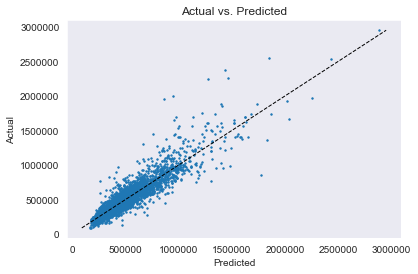

In [45]:
y_pred = np.exp(multi8_reg.predict(X_test_m8))
y_act = np.exp(y_test_m8)
act_fig, ax = plt.subplots()
sns.set_style("dark")
ax.scatter(y_pred, y_act, s = 2)
ax.plot([y_act.min(), y_act.max()], [y_act.min(), y_act.max()], 'k--', lw=1)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.title('Actual vs. Predicted')
ax.ticklabel_format(style='plain')
plt.savefig('images/act_fig.png', bbox_inches = 'tight');

**Final Observations & Insights:**
<ul>
</ul>
<li>

In [46]:
regression_score = pd.DataFrame(index=['Simple', 'M-1', 'M-3', 'M-6', 'M-8'], columns=['test R^2'])
regression_score['test R^2'] = [simple_reg.score(X_test_s, y_test_s),
                                multi1_reg.score(X_test_m1, y_test_m1),
                                multi3_reg.score(X_test_m3, y_test_m3),
                                multi6_reg.score(X_test_m6, y_test_m6),
                                multi8_reg.score(X_test_m8, y_test_m8)]

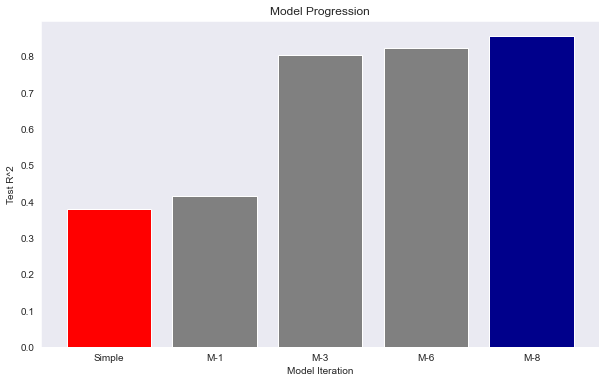

In [49]:
model_score_fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("dark")

ax.bar(regression_score.index, regression_score['test R^2'], color=["red", "grey", "grey", "grey", "darkblue"])
plt.title('Model Progression')
plt.xlabel('Model Iteration')
plt.ylabel('Test R^2')
plt.savefig('images/model_prog.png', bbox_inches = 'tight');

----

# Inferential Model Results

In [50]:
formula = 'price ~ sqft_living + waterfront + C(zipcode) + C(view)'

model_ols = ols(formula=formula, data=housing_pred).fit()

In [51]:
model_summary = model_ols.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     898.1
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:48:41   Log-Likelihood:            -2.4960e+05
No. Observations:               18982   AIC:                         4.994e+05
Df Residuals:                   18906   BIC:                         5.000e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.424e+04   8835.288      2.743      0.006    6921.034    4.16e+04
C(zipcode)[T.98002]   8405.8331   1.16e+04      0.724      0.469   -1.44e+04    3.12e+04
C(zipcode)[T.98003]   7032.6987   1.02e+04      0.690      0.490   -1.29e+04     2.7e+04
C(zipcode)[T.98004]   7.371e+05   1.04e+04     70.965      0.000    7.17e+05    7.57e+05
C(zipcode)[T.98005]    3.73e+05   1.23e+04     30.364      0.000    3.49e+05    3.97e+05
C(zipcode)[T.98006]   3.212e+05   9217.764     34.846      0.000    3.03e+05    3.39e+05
C(zipcode)[T.98007]   2.858e+05   1.26e+04     22.630      0.000    2.61e+05    3.11e+05
C(zipcode)[T.98008]   2.578e+05   1.01e+04     25.432      0.000    2.38e+05    2.78e+05
C(zipcode)[T.98010]   1.042e+05   1.49e+04      6.981      0.000    7.49e+04    1.33e+05
C(zipcode)[T.98011]   1.459e+05   1.14e+04     12.790      0.000    1.24e+05    1.68e+05
C(zipcode)[T.98014]   1.181e+05    1.4e+04      8.417      0.000    9.06e+04    1.46e+05
C(zipcode)[T.98019]   1.023e+05   1.15e+04      8.885      0.000    7.97e+04    1.25e+05
C(zipcode)[T.98022]   1.918e+04   1.09e+04      1.754      0.079   -2250.011    4.06e+04
C(zipcode)[T.98023]  -1.224e+04   8894.980     -1.376      0.169   -2.97e+04    5196.997
C(zipcode)[T.98024]   1.828e+05   1.71e+04     10.687      0.000    1.49e+05    2.16e+05
C(zipcode)[T.98027]   2.086e+05   9460.041     22.047      0.000     1.9e+05    2.27e+05
C(zipcode)[T.98028]   1.357e+05   1.02e+04     13.354      0.000    1.16e+05    1.56e+05
C(zipcode)[T.98029]   2.588e+05      1e+04     25.828      0.000    2.39e+05    2.78e+05
C(zipcode)[T.98030]   9741.7481   1.05e+04      0.925      0.355   -1.09e+04    3.04e+04
C(zipcode)[T.98031]   2.083e+04   1.02e+04      2.036      0.042     773.668    4.09e+04
C(zipcode)[T.98032]     24.6938   1.34e+04      0.002      0.999   -2.62e+04    2.62e+04
C(zipcode)[T.98033]   3.748e+05   9345.353     40.101      0.000    3.56e+05    3.93e+05
C(zipcode)[T.98034]   2.033e+05   8728.875     23.292      0.000    1.86e+05     2.2e+05
C(zipcode)[T.98038]   4.528e+04   8610.397      5.259      0.000    2.84e+04    6.22e+04
C(zipcode)[T.98039]   1.057e+06   2.45e+04     43.060      0.000    1.01e+06    1.11e+06
C(zipcode)[T.98040]   5.642e+05   1.09e+04     51.838      0.000    5.43e+05    5.86e+05
C(zipcode)[T.98042]   2.056e+04   8699.238      2.364      0.018    3511.995    3.76e+04
C(zipcode)[T.98045]   1.204e+05   1.11e+04     10.874      0.000    9.87e+04    1.42e+05
C(zipcode)[T.98052]   2.762e+05   8715.549     31.695      0.000    2.59e+05    2.93e+05
C(zipcode)[T.98053]   2.559e+05   9490.779     26.959      0.000    2.37e+05    2.74e+05
C(zipcode)[T.98055]   3.868e+04   1.06e+04      3.661      0.000     1.8e+04    5.94e+04
C(zipcode)[T.98056]    1.09e+05   9491.426     11.484    

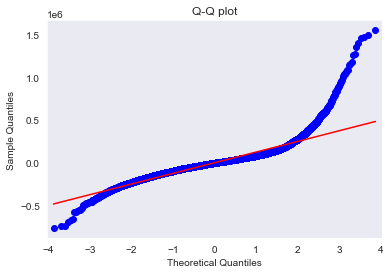

In [53]:
sm.ProbPlot(model_ols.resid).qqplot(line='s');
plt.title('Q-Q plot')
plt.savefig('images/qqplot.png', bbox_inches = 'tight');

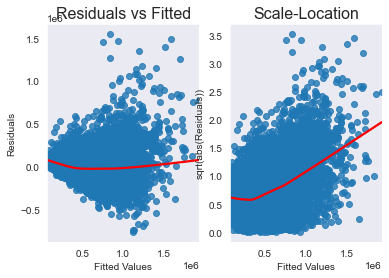

In [54]:
fitted_vals = model_ols.predict()
resids = model_ols.resid
resids_standardized = model_ols.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')
plt.savefig('images/regplot.png', bbox_inches = 'tight');

In [55]:
wtr_df = housing_ols.groupby(by = 'waterfront').mean().reset_index()

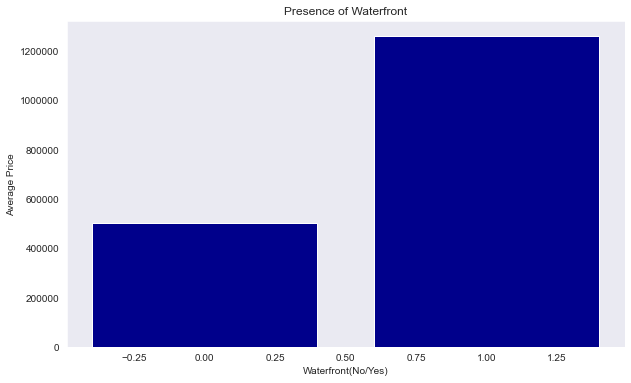

In [56]:
wtr_fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("dark")

plt.bar(wtr_df['waterfront'], wtr_df['price'], color = 'darkblue')
plt.xlabel('Waterfront(No/Yes)')
plt.ylabel('Average Price')
plt.title('Presence of Waterfront')
ax.ticklabel_format(style='plain', axis = 'y')
plt.savefig('images/wtr_fig.png', bbox_inches = 'tight');

In [57]:
view_df = housing_ols.groupby(by = 'view').mean().reset_index()
view_df.sort_values(by = 'price', ascending = True, inplace = True)

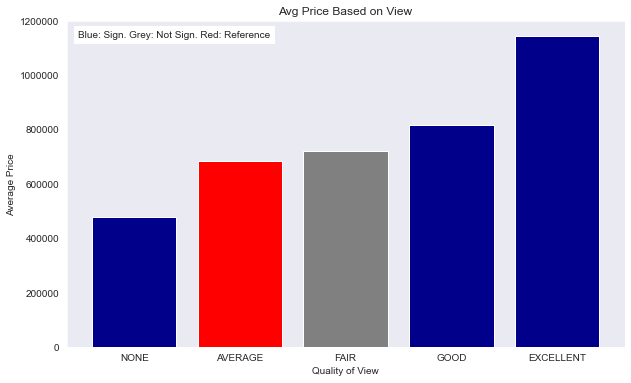

In [58]:
view_fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("dark")
color = ['darkblue', 'red', 'grey', 'darkblue', 'darkblue']
plt.bar(view_df['view'], view_df['price'], color = color)
plt.ylabel('Average Price')
plt.xlabel('Quality of View')
plt.title('Avg Price Based on View')
ax.ticklabel_format(style='plain', axis = 'y')
plt.annotate('Blue: Sign. Grey: Not Sign. Red: Reference', (0.02, .95), backgroundcolor='w', xycoords='axes fraction')
plt.savefig('Images/view.png', bbox_inches = 'tight');

# Conclusions